# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3497984/11490434 [========>.....................] - ETA: 0s

 9699328/11490434 [========================>.....] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:11 - loss: 0.6951

  29/1875 [..............................] - ETA: 3s - loss: 0.5551   

  62/1875 [..............................] - ETA: 3s - loss: 0.4648

  95/1875 [>.............................] - ETA: 2s - loss: 0.4194

 128/1875 [=>............................] - ETA: 2s - loss: 0.3910

 160/1875 [=>............................] - ETA: 2s - loss: 0.3713

 190/1875 [==>...........................] - ETA: 2s - loss: 0.3567

 218/1875 [==>...........................] - ETA: 2s - loss: 0.3455

 243/1875 [==>...........................] - ETA: 2s - loss: 0.3368

 269/1875 [===>..........................] - ETA: 2s - loss: 0.3288

 298/1875 [===>..........................] - ETA: 2s - loss: 0.3209

 318/1875 [====>.........................] - ETA: 2s - loss: 0.3160

 344/1875 [====>.........................] - ETA: 2s - loss: 0.3101

 372/1875 [====>.........................] - ETA: 2s - loss: 0.3043

 399/1875 [=====>........................] - ETA: 2s - loss: 0.2991

 427/1875 [=====>........................] - ETA: 2s - loss: 0.2942

 455/1875 [======>.......................] - ETA: 2s - loss: 0.2897

 482/1875 [======>.......................] - ETA: 2s - loss: 0.2857

 510/1875 [=======>......................] - ETA: 2s - loss: 0.2817

 538/1875 [=======>......................] - ETA: 2s - loss: 0.2781

 566/1875 [========>.....................] - ETA: 2s - loss: 0.2746

 594/1875 [========>.....................] - ETA: 2s - loss: 0.2713

 622/1875 [========>.....................] - ETA: 2s - loss: 0.2682

 651/1875 [=========>....................] - ETA: 2s - loss: 0.2652

 678/1875 [=========>....................] - ETA: 2s - loss: 0.2625

 704/1875 [==========>...................] - ETA: 2s - loss: 0.2600

 732/1875 [==========>...................] - ETA: 2s - loss: 0.2575

 761/1875 [===========>..................] - ETA: 2s - loss: 0.2550

 792/1875 [===========>..................] - ETA: 1s - loss: 0.2524

 824/1875 [============>.................] - ETA: 1s - loss: 0.2499

 852/1875 [============>.................] - ETA: 1s - loss: 0.2478

 880/1875 [=============>................] - ETA: 1s - loss: 0.2458

 908/1875 [=============>................] - ETA: 1s - loss: 0.2438

 936/1875 [=============>................] - ETA: 1s - loss: 0.2420

 965/1875 [==============>...............] - ETA: 1s - loss: 0.2401

 993/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1020/1875 [===============>..............] - ETA: 1s - loss: 0.2367

1050/1875 [===============>..............] - ETA: 1s - loss: 0.2349

1076/1875 [================>.............] - ETA: 1s - loss: 0.2335

1102/1875 [================>.............] - ETA: 1s - loss: 0.2320

1130/1875 [=================>............] - ETA: 1s - loss: 0.2306

1159/1875 [=================>............] - ETA: 1s - loss: 0.2290

1188/1875 [==================>...........] - ETA: 1s - loss: 0.2276

1217/1875 [==================>...........] - ETA: 1s - loss: 0.2262

1245/1875 [==================>...........] - ETA: 1s - loss: 0.2249

1273/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1302/1875 [===================>..........] - ETA: 1s - loss: 0.2223

1331/1875 [====================>.........] - ETA: 0s - loss: 0.2210

1358/1875 [====================>.........] - ETA: 0s - loss: 0.2199

1381/1875 [=====================>........] - ETA: 0s - loss: 0.2189

1408/1875 [=====================>........] - ETA: 0s - loss: 0.2178

1434/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1462/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1489/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1515/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1537/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1563/1875 [========================>.....] - ETA: 0s - loss: 0.2120

1590/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1616/1875 [========================>.....] - ETA: 0s - loss: 0.2101

1642/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1700/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1730/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1759/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1788/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1817/1875 [============================>.] - ETA: 0s - loss: 0.2038

1846/1875 [============================>.] - ETA: 0s - loss: 0.2030

1873/1875 [============================>.] - ETA: 0s - loss: 0.2022

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1153

  30/1875 [..............................] - ETA: 3s - loss: 0.1091

  59/1875 [..............................] - ETA: 3s - loss: 0.1093

  87/1875 [>.............................] - ETA: 3s - loss: 0.1093

 117/1875 [>.............................] - ETA: 3s - loss: 0.1093

 144/1875 [=>............................] - ETA: 3s - loss: 0.1091

 170/1875 [=>............................] - ETA: 3s - loss: 0.1090

 200/1875 [==>...........................] - ETA: 2s - loss: 0.1090

 229/1875 [==>...........................] - ETA: 2s - loss: 0.1090

 260/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 294/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 327/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 358/1875 [====>.........................] - ETA: 2s - loss: 0.1087

 390/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 418/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 444/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 467/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 492/1875 [======>.......................] - ETA: 2s - loss: 0.1083

 519/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 545/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 571/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 601/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 630/1875 [=========>....................] - ETA: 2s - loss: 0.1080

 664/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 691/1875 [==========>...................] - ETA: 2s - loss: 0.1078

 718/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 743/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 770/1875 [===========>..................] - ETA: 1s - loss: 0.1076

 802/1875 [===========>..................] - ETA: 1s - loss: 0.1075

 832/1875 [============>.................] - ETA: 1s - loss: 0.1074

 858/1875 [============>.................] - ETA: 1s - loss: 0.1074

 885/1875 [=============>................] - ETA: 1s - loss: 0.1073

 909/1875 [=============>................] - ETA: 1s - loss: 0.1073

 936/1875 [=============>................] - ETA: 1s - loss: 0.1072

 964/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 989/1875 [==============>...............] - ETA: 1s - loss: 0.1071

1014/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1041/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1070/1875 [================>.............] - ETA: 1s - loss: 0.1069

1095/1875 [================>.............] - ETA: 1s - loss: 0.1068

1119/1875 [================>.............] - ETA: 1s - loss: 0.1068

1144/1875 [=================>............] - ETA: 1s - loss: 0.1067

1171/1875 [=================>............] - ETA: 1s - loss: 0.1067

1198/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1227/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1262/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1285/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1310/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1343/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1370/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1396/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1422/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1449/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1475/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1503/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1532/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1565/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1597/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1631/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1665/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1697/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1731/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1753/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1777/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1802/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1827/1875 [============================>.] - ETA: 0s - loss: 0.1055

1850/1875 [============================>.] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0971

  27/1875 [..............................] - ETA: 3s - loss: 0.0968

  51/1875 [..............................] - ETA: 3s - loss: 0.0969

  79/1875 [>.............................] - ETA: 3s - loss: 0.0970

 107/1875 [>.............................] - ETA: 3s - loss: 0.0972

 134/1875 [=>............................] - ETA: 3s - loss: 0.0974

 167/1875 [=>............................] - ETA: 3s - loss: 0.0975

 190/1875 [==>...........................] - ETA: 3s - loss: 0.0975

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 243/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 303/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 357/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 436/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0976

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0976

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0976

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0976

 695/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 723/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 768/1875 [===========>..................] - ETA: 2s - loss: 0.0976

 794/1875 [===========>..................] - ETA: 2s - loss: 0.0976

 820/1875 [============>.................] - ETA: 1s - loss: 0.0976

 847/1875 [============>.................] - ETA: 1s - loss: 0.0976

 874/1875 [============>.................] - ETA: 1s - loss: 0.0975

 900/1875 [=============>................] - ETA: 1s - loss: 0.0975

 923/1875 [=============>................] - ETA: 1s - loss: 0.0975

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0975

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1086/1875 [================>.............] - ETA: 1s - loss: 0.0975

1112/1875 [================>.............] - ETA: 1s - loss: 0.0975

1140/1875 [=================>............] - ETA: 1s - loss: 0.0975

1164/1875 [=================>............] - ETA: 1s - loss: 0.0975

1192/1875 [==================>...........] - ETA: 1s - loss: 0.0975

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0975

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0975

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0975

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0975

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0975

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0975

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1547/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1818/1875 [============================>.] - ETA: 0s - loss: 0.0974

1847/1875 [============================>.] - ETA: 0s - loss: 0.0974

1871/1875 [============================>.] - ETA: 0s - loss: 0.0974

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0874

  28/1875 [..............................] - ETA: 3s - loss: 0.0947

  57/1875 [..............................] - ETA: 3s - loss: 0.0959

  86/1875 [>.............................] - ETA: 3s - loss: 0.0961

 113/1875 [>.............................] - ETA: 3s - loss: 0.0963

 143/1875 [=>............................] - ETA: 3s - loss: 0.0963

 168/1875 [=>............................] - ETA: 3s - loss: 0.0963

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 312/1875 [===>..........................] - ETA: 2s - loss: 0.0964

 337/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 437/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 460/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 511/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 725/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 826/1875 [============>.................] - ETA: 2s - loss: 0.0964

 854/1875 [============>.................] - ETA: 2s - loss: 0.0964

 881/1875 [=============>................] - ETA: 2s - loss: 0.0964

 908/1875 [=============>................] - ETA: 2s - loss: 0.0963

 935/1875 [=============>................] - ETA: 2s - loss: 0.0963

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1063/1875 [================>.............] - ETA: 1s - loss: 0.0963

1088/1875 [================>.............] - ETA: 1s - loss: 0.0963

1108/1875 [================>.............] - ETA: 1s - loss: 0.0963

1126/1875 [=================>............] - ETA: 1s - loss: 0.0963

1150/1875 [=================>............] - ETA: 1s - loss: 0.0963

1176/1875 [=================>............] - ETA: 1s - loss: 0.0963

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1391/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1820/1875 [============================>.] - ETA: 0s - loss: 0.0961

1845/1875 [============================>.] - ETA: 0s - loss: 0.0961

1870/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0902

  19/1875 [..............................] - ETA: 5s - loss: 0.0993

  43/1875 [..............................] - ETA: 4s - loss: 0.0979

  66/1875 [>.............................] - ETA: 4s - loss: 0.0974

  89/1875 [>.............................] - ETA: 4s - loss: 0.0972

 113/1875 [>.............................] - ETA: 4s - loss: 0.0971

 135/1875 [=>............................] - ETA: 4s - loss: 0.0969

 158/1875 [=>............................] - ETA: 3s - loss: 0.0968

 182/1875 [=>............................] - ETA: 3s - loss: 0.0966

 208/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 232/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 254/1875 [===>..........................] - ETA: 3s - loss: 0.0964

 279/1875 [===>..........................] - ETA: 3s - loss: 0.0963

 302/1875 [===>..........................] - ETA: 3s - loss: 0.0962

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 346/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 371/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 397/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 424/1875 [=====>........................] - ETA: 3s - loss: 0.0960

 452/1875 [======>.......................] - ETA: 3s - loss: 0.0960

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 584/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 611/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 683/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 780/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 831/1875 [============>.................] - ETA: 2s - loss: 0.0956

 855/1875 [============>.................] - ETA: 2s - loss: 0.0956

 874/1875 [============>.................] - ETA: 2s - loss: 0.0956

 899/1875 [=============>................] - ETA: 2s - loss: 0.0956

 926/1875 [=============>................] - ETA: 2s - loss: 0.0956

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1087/1875 [================>.............] - ETA: 1s - loss: 0.0955

1113/1875 [================>.............] - ETA: 1s - loss: 0.0955

1138/1875 [=================>............] - ETA: 1s - loss: 0.0955

1164/1875 [=================>............] - ETA: 1s - loss: 0.0955

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1313/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1824/1875 [============================>.] - ETA: 0s - loss: 0.0954

1847/1875 [============================>.] - ETA: 0s - loss: 0.0954

1873/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

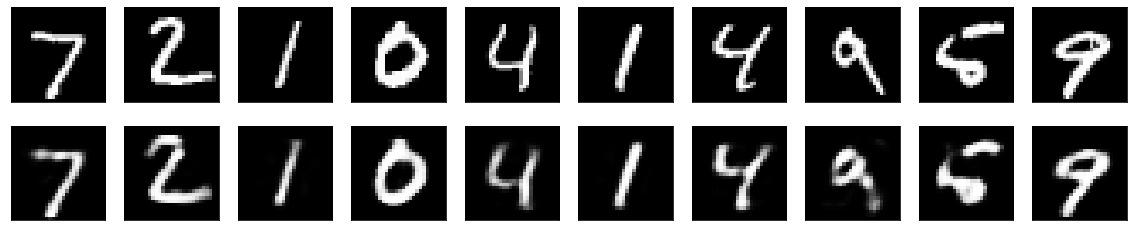

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
